This notebook has porpuse of showing the calculation of Hubble parameter for the GILA model, and compare it with the Standard Cosmological Model. Let's call some libraries

In [76]:
import time
import numpy as np
from scipy.constants import c as c_light  # units of m/s
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
c_light_km = c_light / 1000 # units of km/s

FIrstly, let's define the function that characterise our model.

In [77]:
def F_H(H, params):     
    lamb, L, beta, L_bar = params
    FH = H**2 - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10) \
              + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2)
    return FH


def F_H_prime(H, params):
    lamb, L, beta, L_bar = params
    aux = np.exp(-beta*(L_bar*H)**10) * beta * (L_bar*H)**4 * (-3 - 5 * beta * (L_bar*H)**10) +\
          np.exp(lamb*(L*H)**2) * lamb * (L*H)**6 * (4 + lamb*(L*H)**2)
    FH_prime = 2 * H * (1 + aux) 
    return FH_prime

def omega_luisa_to_CDM(beta, L_bar, H0, omega_m_luisa):
    factor = F_H(H0, [0, 1e-27/H0, beta, L_bar/H0]) / H0**2
    omega_cdm = omega_m_luisa * factor
    return omega_cdm

def omega_CDM_to_luisa(beta, L_bar, H0, omega_lcdm):
    factor_inv = H0**2 / F_H(H0, [0, 1e-27/H0, beta, L_bar/H0]) 
    omega_luisa = omega_lcdm * factor_inv
    return omega_luisa

Now we define the system of equation. 

In [ ]:
def rk4_step(f, y, t, dt):
    """
    Perform a single RK4 step.
    
    Parameters:
    f : function
        The function that returns dy/dt. It must be of the form f(t, y).
    y : array-like
        The current value of the dependent variable.
    t : float
        The current value of the independent variable (usually time).
    dt : float
        The step size.
        
    Returns:
    y_next : array-like
        The value of the dependent variable after the step.
    """
    k1 = f(t, y)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2)
    k4 = f(t + dt, y + dt * k3)
    y_next = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

def rk4(f, y0, t):
    """
    Solve an ODE using the RK4 method.
    
    Parameters:
    f : function
        The function that returns dy/dt. It must be of the form f(t, y).
    y0 : array-like
        The initial value of the dependent variable.
    t : array-like
        The array of time points at which to solve the ODE.
        
    Returns:
    y : array-like
        The array of values of the dependent variable at each time point.
    """
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        y[i] = rk4_step(f, y[i-1], t[i-1], dt)
    return y

In [78]:
def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'HS'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3 #Irrelevant for the ODEs
    kappa = 1

    [lamb, L, b, L_bar, H_0, omega_m_0] = params_ode


    #omega_m_0 = 0.999916 #omega_m_0 es el de Luisa
    omega_r_0 = 1 - omega_m_0

    F_H0 = F_H(H_0, [lamb, L, b, L_bar])

    if lcdm == True:
        rho_crit_0 = H_0**2 / kappa        
    else:
        rho_crit_0 = F_H0 / kappa

    #print(omega_m_0,F_H0,rho_crit_0)
    
    a = 1/(1+z)

    rho_r = rho_crit_0 * omega_r_0 * a**(-4)
    rho_m = rho_crit_0 * omega_m_0 * a**(-3)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [lamb, L, b, L_bar]))     
    #print(s)
    
    return s


Now we define the function that integrates the ODEs for the given cosmological model.

In [79]:
def integrator(physical_params, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, b, H0, omega_m_luisa = physical_params
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    ode_params = [0, 1e-27/H0, b, L_bar/H0, H0, omega_m_luisa]
    
    t = np.linspace(initial_z, final_z, zs_int)
    y = rk4(system_equations, H0, t)

    zs_final = t
    Hs_final = y

    #sol = solve_ivp(system_equations, (initial_z,final_z),
    #                [H0], t_eval=zs_int, args = [ode_params],
    #                rtol=rtol, atol=atol,
    #                method=method)
        

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    #zs_final = sol.t
    #Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

The Standard Cosmological model $H(z)$ is defined by

In [80]:
def H_LCDM(z, omega_m, H_0):
    '''
    Calculation of the Hubble parameter.
    Here we neclect the radiation (it holds 
    that \Omega_r + \Omega_m + \Omega_L = 1).
    '''
    
    omega_lambda = 1 - omega_m
    H = H_0 * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)
    
    return H

Finally, we plot $H(z)$ for different values of the scale $\bar{L}$

In [85]:
# Set physical parameters
H_0 = 70
b = 0.1
omega_m_luisa = 0.999916
#omega_m = 0.3

#L_bar = 1.4 # In units of H0   
L_bars = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])
L_bars = np.array([0.4, 0.5, 0.6, 0.7])
#L_bars = np.array([0.8, 0.9, 1.0, 1.1])

final_z = 3
#final_z = 10000


No handles with labels found to put in legend.


\Omega_m^LCDM$=0.99735624188115
\Omega_m^LCDM$=0.9936671352704941
\Omega_m^LCDM$=0.9869649220296364
\Omega_m^LCDM$=0.9759757377577655


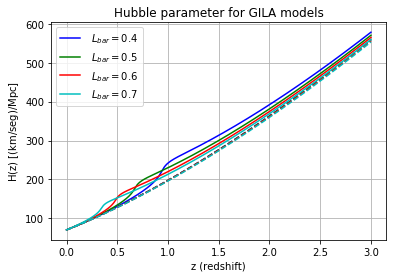

In [87]:
# Plot Hubble diagrams for different models
plt.figure()
plt.title('Hubble parameter for GILA models')
plt.xlabel('z (redshift)')
plt.ylabel(r'H(z) $\rm [(km/seg)/Mpc]$')
plt.legend(loc='best')
plt.grid(True)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors1 = ['b--', 'g--', 'r--', 'c--', 'm--', 'y--', 'k--']

for i, L_bar in enumerate(L_bars):
    physical_params = [L_bar, b, H_0, omega_m_luisa] #L_bar in units of H0
    redshifts, hubble_values = integrator(physical_params, final_z=final_z)
    omega_m = omega_luisa_to_CDM(b, L_bar, H_0, omega_m_luisa) #L_bar in units of H0 (inside the function L_bar is divided by H0)
    print(r'\Omega_m^LCDM$={}'.format(omega_m))

    # Plot GILA Hubble function
    plt.plot(redshifts, hubble_values,colors[i], label=f' $L_{{bar}} = {L_bar}$')
    plt.legend(loc='best')
    
    #Plot LCDM Hubble parameter
    redshift_LCDM = np.linspace(0, final_z, int(10**5))
    plt.plot(redshift_LCDM, H_LCDM(redshift_LCDM,omega_m,H_0),colors1[i]) 

plt.show()

It can be seen that the step on $H(z)$ that characterize the GILA model appears at higher redshifts  when $\bar{L}$ is lower.